# A5 - Python

This assignment will cover topics of association analysis.

Make sure that you keep this notebook named as "a5.ipynb" 

Any other packages or tools, outside those listed in the assignments or Canvas, should be cleared
by Dr. Brown before use in your submission.

## Q0 - Setup

The following code looks to see whether your notebook is run on Gradescope (GS), Colab (COLAB), or the linux Python environment you were asked to setup.

In [1]:
import re 
import os
import platform 
import sys 

# flag if notebook is running on Gradescope 
if re.search(r'amzn', platform.uname().release): 
    GS = True
else: 
    GS = False

# flag if notebook is running on Colaboratory 
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

# flag if running on Linux lab machines. 
cname = platform.uname().node
if re.search(r'(guardian|colossus|c28|lebrown|rovernet)', cname):
    LLM = True 
else: 
    LLM = False

print("System: GS - %s, COLAB - %s, LLM - %s" % (GS, COLAB, LLM))

System: GS - False, COLAB - False, LLM - True


## Notebook Setup

It is good practice to list all imports needed at the top of the notebook. You can import modules in later cells as needed, but listing them at the top clearly shows all which are needed to be available / installed.

If you are doing development on Colab, the otter-grader package is not available, so you will need to install it with pip (uncomment the cell directly below).

In [2]:
# Only uncomment if you developing on Colab 
# if COLAB == True: 
#     print("Installing otter:")
#     !pip install otter-grader==4.2.0 

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

import warnings
warnings.filterwarnings('ignore')

# Package for Autograder 
import otter 
grader = otter.Notebook()

In [4]:
grader.check("q0")

q0 results: All test cases passed!

# Q1 - Association Analysis

For this problem, you will analyze a portion of the Instacart Online Grocery Shopping Dataset from 2017.  The full data set is available if you are interested.  
https://www.instacart.com/datasets/grocery-shopping-2017

The original dataset has 3 million orders.  We will work with a smaller data set.  

You will use the following files for this analysis: 

* `orders_products.csv`  
* `products.csv` 



Structure of the files, `products_orders`: 
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

File structure for `products`: 
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

You can connect the `product_id` with the name of the product, `product_name` in the `products.csv` file. 

## Q1(a) - Load the Data

Load the 2 data files mentioned above.  

You will need to transform this data into a boolean transaction DataFrame `orders`.  

These boolean transaction DataFrame will have rows corresponding to orders / transaction with the `order_id` as the row index.  The DataFrame will have columns corresponding to products with the `product_name` as the column names.  The DataFrame is boolean and entry [i, j] is : "False" meaning this product, j, was not purchased in order, i, and "True" means product, j, was purchased in order, i. 

The rows in the DataFrame should be in order of `order_id`.  The columns should be ordered in alphanumeric ordering of the `product_name`.

Note, you can not use the `mlxtend.TransactionEncoder` function for this because it expects data as lists of lists.  

*Hint:* several `pandas` functions such as `join`, `merge`, or `pivot` may be useful to construct the `orders` DataFrame.

Also, calculate the mean/max number of products per order for the `orders` dataset: `mean_num_prods` and `max_num_prods` 

<br>
After creating the `orders` DataFrame, capture aspects of the data: 

* `orders_num_rows` 
* `orders_num_cols` 
* `orders_col_names` 

Then, save off a slice of the data frame, `orders_small`, the first 50 rows the first 100 items. 

In [9]:
# Load and prepare the data 
prods_orders = pd.read_csv('products_orders.csv')
prods = pd.read_csv('products.csv')

# Merge products_orders with products to get product names
merged_df = pd.merge(prods_orders, prods, on='product_id')

# Create a dataframe with order_id as index and product_name as column
orders = merged_df.pivot(index='order_id', columns='product_name', values='product_id')

# Sort columns in alphanumeric order
orders = orders.reindex(sorted(orders.columns), axis=1)

# Sort rows by order_id
orders.sort_index(inplace=True)

# Convert entries to boolean (True if purchased, false otherwise)
orders = orders.notnull()

# Capture aspects of the data
orders_num_rows = orders.shape[0]
orders_num_cols = orders.shape[1]
orders_col_names = sorted(orders.columns.tolist())

# Calculate mean and max number of products per order
mean_num_prods = orders.sum(axis=1).mean()
max_num_prods = orders.sum(axis=1).max()

# Save off a slice of the data frame
orders_small = orders.iloc[:50, :100]

# Display the first few rows of the orders DataFrame
print(orders.head())

print("Mean number of products per order:", mean_num_prods)
print("Max number of products per order:", max_num_prods)

# Clean up unneeded raw data
del prods_orders, prods

product_name  #2 Coffee Filters  0% Fat Free Organic Milk  \
order_id                                                    
1                         False                     False   
36                        False                     False   
38                        False                     False   
96                        False                     False   
98                        False                     False   

product_name  0% Fat Organic Greek Vanilla Yogurt  \
order_id                                            
1                                           False   
36                                          False   
38                                          False   
96                                          False   
98                                          False   

product_name  0% Fat Superfruits Greek Yogurt  0% Greek Strained Yogurt  \
order_id                                                                  
1                                       False     

In [10]:
grader.check("q1a")

q1a results:
    q1a - 1 result:
        ✅ Test case passed

    q1a - 2 result:
        ✅ Test case passed

    q1a - 3 result:
        ❌ Test case failed
        Trying:
            all(orders_col_names[[5, 15, 103, 987]] == ['1 Apple + 1 Pear Fruit Bar', '10 Grain Pancake & Waffle Mix', '2nd Foods Organic  Pear and Spinach Baby Food', 'Chocolate Bar Milk Stevia Sweetened Salted Almond'])
        Expecting:
            True
        **********************************************************************
        Line 1, in q1a 2
        Failed example:
            all(orders_col_names[[5, 15, 103, 987]] == ['1 Apple + 1 Pear Fruit Bar', '10 Grain Pancake & Waffle Mix', '2nd Foods Organic  Pear and Spinach Baby Food', 'Chocolate Bar Milk Stevia Sweetened Salted Almond'])
        Exception raised:
            Traceback (most recent call last):
              File "/home/campus14/dmmunson/.conda/envs/cs4821/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1a 2[0]>", line 1, in <module>
                all(orders_col_names[[5, 15, 103, 987]] == ['1 Apple + 1 Pear Fruit Bar', '10 Grain Pancake & Waffle Mix', '2nd Foods Organic  Pear and Spinach Baby Food', 'Chocolate Bar Milk Stevia Sweetened Salted Almond'])
            TypeError: list indices must be integers or slices, not list

    q1a - 4 result:
        ✅ Test case passed

    q1a - 5 result:
        ✅ Test case passed

    q1a - 6 result:
        ✅ Test case passed

    q1a - 7 result:
        ✅ Test case passed

    q1a - 8 result:
        ✅ Test case passed

    q1a - 9 result:
        ✅ Test case passed

    q1a - 10 result:
        ✅ Test case passed

<!-- BEGIN QUESTION -->

## Q1(b) - Explore the Data 

Create a density plot showing the number of products per order using the `orders` data set.



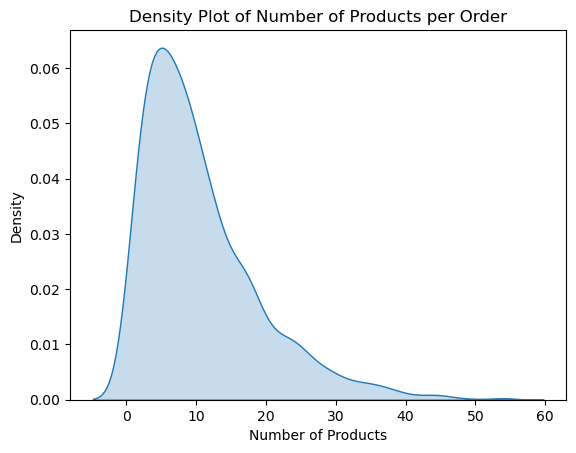

In [14]:
# Calculate the number of products per order
num_products_per_order = orders.sum(axis=1)

# Create a density plot
sns.kdeplot(num_products_per_order, shade=True)
plt.title('Density Plot of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Density')
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q1(c) - Explore the Data, part 2 

For the `orders` dataset, create an top 15 item frequency plot, that is plot the top 15 most frequently purchased items. This should be a bar plot with items vs. frequency (relative support).

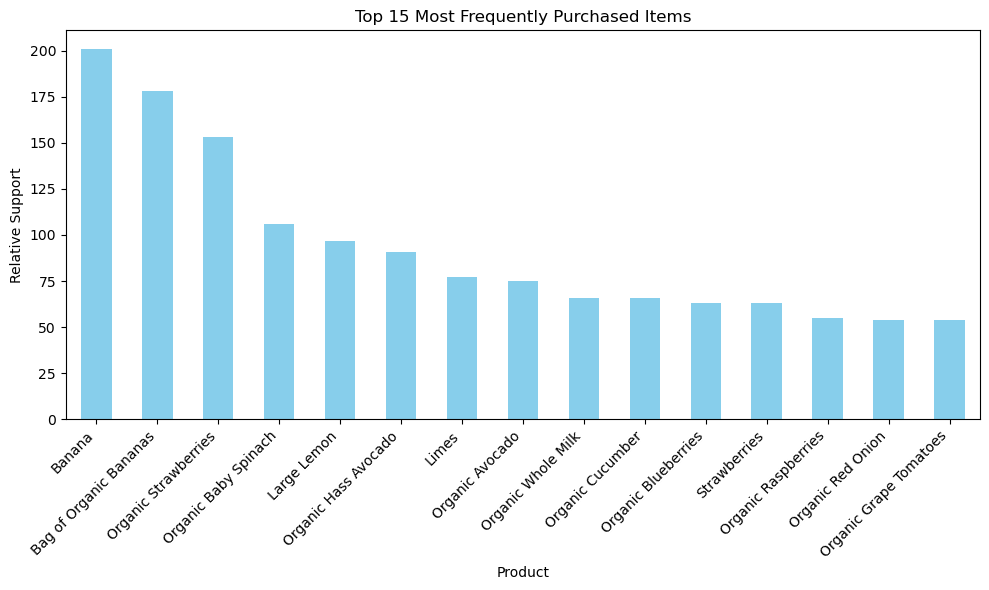

In [17]:
# Plot top 15 most frequently purchased product (by relative support) 

# Calculate the frequency of each product
product_frequency = orders.sum().sort_values(ascending=False)

# Take the top 15 most frequently purchased items
top_15_products = product_frequency.head(15)

# Calculate relative support (frequency normalized by total number of orders)
relative_support = top_15_products / orders.shape[0]

# Create a bar plot
plt.figure(figsize=(10, 6))
top_15_products.plot(kind='bar', color='skyblue')
plt.title('Top 15 Most Frequently Purchased Items')
plt.xlabel('Product')
plt.ylabel('Relative Support')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q1(d) - Explore the Data, part 3 

For the `orders` dataset, create an histogram of the number of times an item is purchased. You may want to consider using log scaling to view the data distribution more easily. 

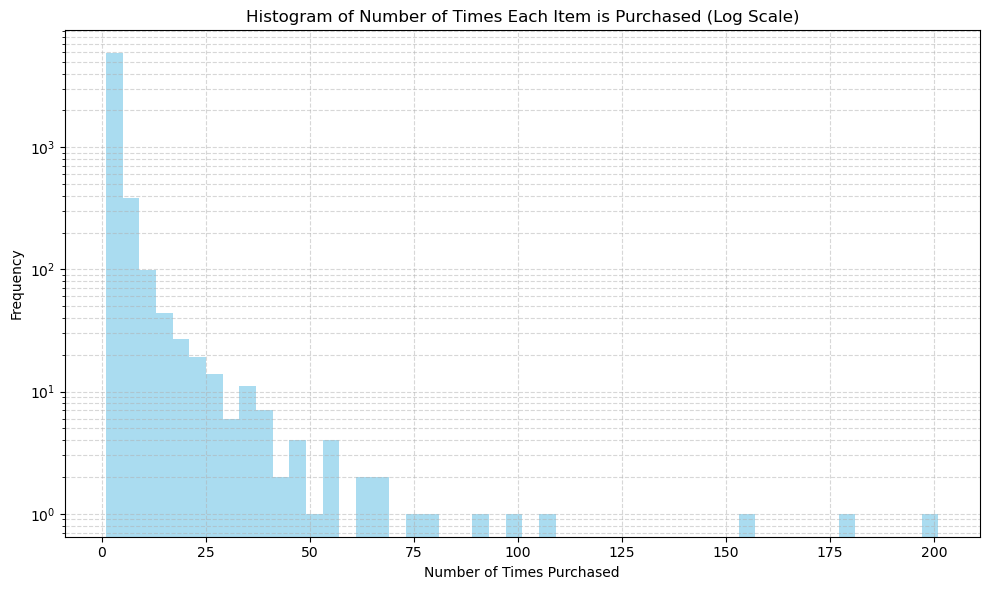

In [19]:
# Plot histogram of number of purchases per item. 

# Calculate the frequency of each product
product_frequency = orders.sum()

# Plot the histogram with log scaling
plt.figure(figsize=(10, 6))
plt.hist(product_frequency, bins=50, color='skyblue', alpha=0.7, log=True)
plt.title('Histogram of Number of Times Each Item is Purchased (Log Scale)')
plt.xlabel('Number of Times Purchased')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


<!-- END QUESTION -->

## Q1(e) - Apriori 

For the `orders` dataset, use Apriori to find association rules, `rules` with a minimum relative support of 0.0035 and confidence of 0.5.  

In `q1e_df` sort the rules by leverage (descending order), then by confidence (in descending order)  and return the top 20 rules.

Note, the minimum support level is rather high given the information plotted in Q1(c) and Q1(d). However, this was done to avoid using too much memory (lower support values will require 15-20 GB memory). 

In [22]:
# Run Apriori as instructed

# Run Apriori to find frequent itemsets
frequent_itemsets = apriori(orders, min_support=0.0035, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort the rules by leverage (descending order), then by confidence (descending order)
sorted_rules = rules.sort_values(by=['leverage', 'confidence'], ascending=[False, False])

# Select the top 20 rules
q1e_df = sorted_rules.head(20)

q1e_df.iloc[0:10, [0, 1, 4, 5, 7]]

,antecedents,consequents,support,confidence,leverage
5,(Honeycrisp Apple),(Banana),0.011605,0.500000,0.008597
18,"(Organic Strawberries, Organic Hass Avocado)",(Bag of Organic Bananas),0.007737,0.521739,0.006035
26,"(Organic Avocado, Large Lemon)",(Limes),0.005803,0.529412,0.005259
25,"(Limes, Organic Avocado)",(Large Lemon),0.005803,0.562500,0.005158
6,(Roma Tomato),(Banana),0.006447,0.526316,0.004860
32,"(Organic Red Onion, Organic Avocado)",(Limes),0.005158,0.800000,0.004838
33,"(Limes, Organic Avocado)",(Organic Red Onion),0.005158,0.500000,0.004799
31,"(Organic Red Onion, Limes)",(Organic Avocado),0.005158,0.533333,0.004690
19,"(Bag of Organic Bananas, Organic Large Extra F...",(Organic Strawberries),0.005803,0.500000,0.004658
20,"(Organic Large Extra Fancy Fuji Apple, Organic...",(Bag of Organic Bananas),0.005803,0.529412,0.004545


In [23]:
grader.check("q1e")

q1e results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q1(f) - Apriori, part 2

Create a scatterplot of the rules, plotting support vs. confidence colored by lift value. 


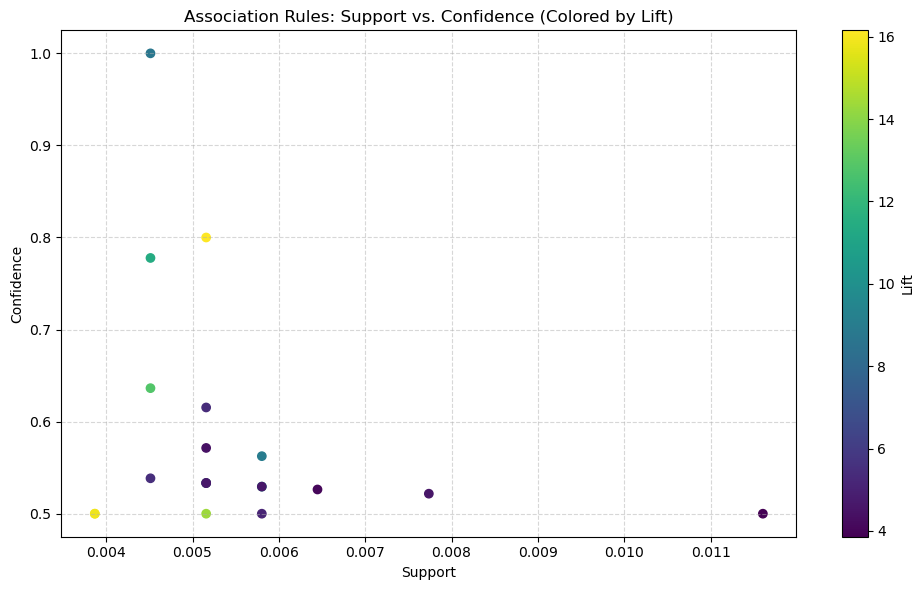

In [28]:
# Plot the results of Apriori

# Create the scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(q1e_df['support'], q1e_df['confidence'], c=q1e_df['lift'], cmap='viridis')
plt.colorbar(scatter, label='Lift')
plt.title('Association Rules: Support vs. Confidence (Colored by Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

## Q1(g) - FPGrowth 

For the `orders` dataset, use FPGrowth to find association rules, `rules2` with a minimum support of 0.0035 and confidence of 0.5.

Sort the rules by conviction (descending order), then by support (descending order).  Store the top 20 rules in `q1g_df`.

Note, the relative speed for FPGrowth over Apriori.

In [33]:
# Run FPGrowth as instructed

from mlxtend.frequent_patterns import fpgrowth, association_rules

# Run FP-Growth to find frequent itemsets
frequent_itemsets = fpgrowth(orders, min_support=0.0035, use_colnames=True)

# Generate association rules
rules2 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort the rules by conviction (descending order), then by support (descending order)
sorted_rules2 = rules2.sort_values(by=['conviction', 'support'], ascending=[False, False])

# Select the top 20 rules
q1g_df = sorted_rules2.head(20)

q1g_df.iloc[0:10, [0, 1, 4, 5, 8]]

,antecedents,consequents,support,confidence,conviction
22,"(Organic Large Extra Fancy Fuji Apple, Organic...",(Bag of Organic Bananas),0.004513,1.000000,inf
26,"(Organic Plain Greek Whole Milk Yogurt, Organi...",(Bag of Organic Bananas),0.003868,1.000000,inf
4,"(Asparagus, Limes)",(Large Lemon),0.003868,0.857143,6.562218
33,"(Organic Red Onion, Organic Avocado)",(Limes),0.005158,0.800000,4.751773
3,"(Limes, Organic Garnet Sweet Potato (Yam))",(Organic Baby Spinach),0.004513,0.777778,4.192456
16,"(Banana, Organic Cilantro)",(Limes),0.003868,0.750000,3.801418
25,"(Organic Plain Greek Whole Milk Yogurt, Bag of...",(Organic Hass Avocado),0.003868,0.750000,3.765313
5,"(Asparagus, Large Lemon)",(Limes),0.003868,0.666667,2.851064
31,"(Organic Red Onion, Large Lemon)",(Limes),0.004513,0.636364,2.613475
2,"(Organic Garnet Sweet Potato (Yam), Organic Ha...",(Organic Baby Spinach),0.003868,0.600000,2.329142


In [34]:
grader.check("q1g")

q1g results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

**NOTE** the submission must be run on the campus linux machines.  See the instruction in the Canvas assignment.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()